<img src="../images/headers/nb_3.svg"  width="1080" height="220">

# Import Section

In [1]:
import multiprocessing

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.random import sample_without_replacement
from skopt import BayesSearchCV
from xgboost import XGBClassifier, plot_importance

from roaf import visualization

In [2]:
%matplotlib inline
plt.style.use("dark_background")
plt.set_cmap("Dark2")
sns.set_palette("Dark2")

<Figure size 640x480 with 0 Axes>

# Setup of notebook parameters
These parameters can be overwritten with papermill parameterization, namely for testing purposes.

<table>
  <tr>
    <th> Parameter </td>
    <th> Description </td>
  </tr>
  <tr>
    <td> fast_execution </td>
    <td> Should be set to <i>True</i> if the focus is on testing and not on prediction
      quality </td>
  </tr>
  <tr>
    <td> plot_dir </td>
    <td> The output directory for the plots </td>
  </tr>
  <tr>
    <td> max_sample_size </td>
    <td> The number of data points used for machine learning and validation. <br>
          If set to <i>None</i>, all the data (after undersampling) will be used</td>
  </tr>
  <tr>
    <td> n_plot </td>
    <td> The number of data points to plot in certain figures </td>
  </tr>
  <tr>
    <td> n_cv </td>
    <td> Parameter for k-fold cross-validation used in parameter optimization</td>
  </tr>
  <tr>
    <td> n_permutation_repetitions </td>
    <td> The number of permutations to be performed to find the importance of
    features in trained models</td>
  </tr>
  <tr>
    <td> n_random_forest_estimators </td>
    <td> The number of estimators in the random forest model</td>
  </tr>

</table>

In [3]:
FAST_EXECUTION = False
PLOT_DIR = "../images/"
PLOT_FILE_FORMATS = ["png"]
MAX_SAMPLE_SIZE = None
N_PLOT = 15
N_CV = 5
N_PERMUTATION_REPETITIONS = 10
N_RANDOM_FOREST_ESTIMATORS = 100
VERBOSE = 0

In [4]:
df = pd.read_parquet("../data/processed/df_by_person.parquet")

# Data Preprocessing for Machine Learning
The data was already cleaned in notebook 1, but this cleaning was meant for general purpose,
so that more data was retained for visualizations in notebook 2.

In this notebook, the data will be prepared for the application of machine learning models.
This preparation will be done in these steps:
1. Dropping all remaining columns that can not be used for machine learning
2. One-hot encoding of categorical variables
3. Undersampling to get a balanced subset of data
4. Scaling
5. Splitting the data into training and testing data
6. Saving the preprocessed datasets to make them available for the neural networks in notebook 4.

## Dropping all remaining columns that can not be used for machine learning

In [5]:
df_ml = (
    df.select_dtypes(include=np.number)
    .drop(columns=["accident_id", "accident_id_y"])
    .dropna(axis=1, how="any")
)

## One-hot encoding of categorical variables

In [6]:
df_ml = pd.get_dummies(
    data=df_ml,
    columns=[
        "daylight",
        "built_up_area",
        "intersection_category",
        "weather",
        "collision_category",
        "road_admin_category",
        "traffic_regime",
        "reserved_lane",
        "plane_layout",
        "surface_condition",
        "infrastructure",
        "location",
        "is_weekend",
        "role",
    ],
)

## Undersampling to get a balanced subset of data or to decrease computation time

In [7]:
features = df_ml.drop(columns="severity")
feature_columns = features.columns
target = df_ml["severity"]
random_under_sampler = RandomUnderSampler()
features, target = random_under_sampler.fit_resample(X=features, y=target)

In [8]:
sample_size = len(target)
if MAX_SAMPLE_SIZE is not None:
    if sample_size > MAX_SAMPLE_SIZE:
        sample_idx = sample_without_replacement(
            n_population=sample_size,
            n_samples=MAX_SAMPLE_SIZE,
            random_state=0,
        )
        features = features.iloc[sample_idx]
        target = target.iloc[sample_idx]

print(sample_size)

28491


## Scaling

In [9]:
scaler = StandardScaler()
features = scaler.fit_transform(features)

## Splitting the data into training and testing data

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.2,
    random_state=0,
)

In [11]:
# Reconvert the features to DataFrames in order to keep the feature names
X_train = pd.DataFrame(data=X_train)
X_test = pd.DataFrame(data=X_test)
X_train.columns = feature_columns
X_test.columns = feature_columns

## Saving the preprocessed datasets
The preprocessed and splitted dataset will be exported to parquet so that it can be used in
notebook 4 (artificial neural networks). Parquet is used again as the file format for its
low requirements regarding disk space.

In [12]:
TRAIN_FILENAME = "Xy_train"
TEST_FILENAME = "Xy_test"

if FAST_EXECUTION:
    TRAIN_FILENAME = "TESTING_" + TRAIN_FILENAME
    TEST_FILENAME = "TESTING_" + TEST_FILENAME

Xy_train = pd.concat([X_train, y_train.reset_index(drop=True)], axis=1)
Xy_test = pd.concat([X_test, y_test.reset_index(drop=True)], axis=1)

Xy_train.to_parquet("../data/processed/" + TRAIN_FILENAME + ".parquet")
Xy_test.to_parquet("../data/processed/" + TEST_FILENAME + ".parquet")

# XGBoost
## Setup and training

In [13]:
xgb_clf = XGBClassifier(n_jobs=multiprocessing.cpu_count() // 2)

param_spaces = {
    "max_depth": [2, 4, 6],
    "n_estimators": [100, 200],
    "learning_rate": [0.05, 0.1],
}

bayes_search = BayesSearchCV(
    xgb_clf, param_spaces, cv=N_CV, n_jobs=2, n_iter=4, verbose=0
)
bayes_search.fit(X_train, y_train)

BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, gpu_id=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None...
                                      max_cat_threshold=None,
                                      max_cat_to_onehot=None,
                                      max_delta_step=None, max_depth=None,
                                      max_leaves=None, min_child_weight=None,
                                      missing=nan, monotone_constraints=None,
                                      n_estimators=100, n_jobs=4,
                                      num_parallel_tree=None, predictor=None,
                                      random_state=None, ...),
              n_iter=4, n_jobs=2,
              search_spaces={'learning_rate': [0.05, 0.1],
                             'max_depth': [2, 4, 6],
                             'n_estimators': [100, 200]})

## Evaluation and Interpretation

              precision    recall  f1-score   support

           0       0.67      0.77      0.71      1869
           1       0.62      0.47      0.53      1906
           2       0.69      0.75      0.72      1924

    accuracy                           0.66      5699
   macro avg       0.66      0.66      0.65      5699
weighted avg       0.66      0.66      0.65      5699



['../images/rxgb_confusion_matrix.png', '../images/rxgb_confusion_matrix.svg']

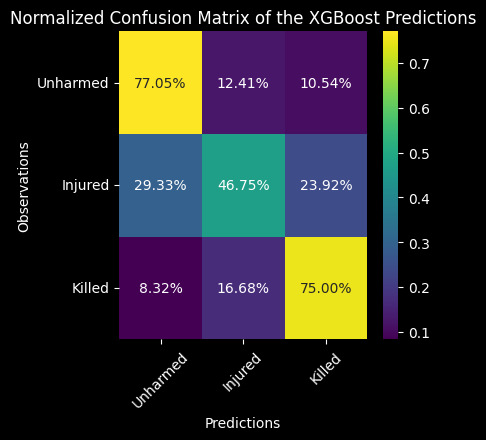

In [14]:
best_xgb = bayes_search.best_estimator_

# Predict
y_pred = best_xgb.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred))

# Plot confusion matrix
visualization.plot_confusion_matrix(
    y_test, y_pred, "XGBoost", normalize="true", figsize=(4, 4)
)

# Save figure
FILENAME = "rxgb_confusion_matrix"
visualization.savefig(basename=FILENAME, filepath=PLOT_DIR)

When interpreting precision and recall for machine learning models, it is important to keep in
mind, that the test data is balanced while the real-world data is not. That means, that we would
expect an accuracy of 0.33 for a random guess.

The model does a good job predicting deadly injuries. Unharmed persons are detected with a high
recall but with lower precision. It shows a lower performance for injured persons. Here,
especially the recall is very low.

['../images/rxgb_feat_importance.png']

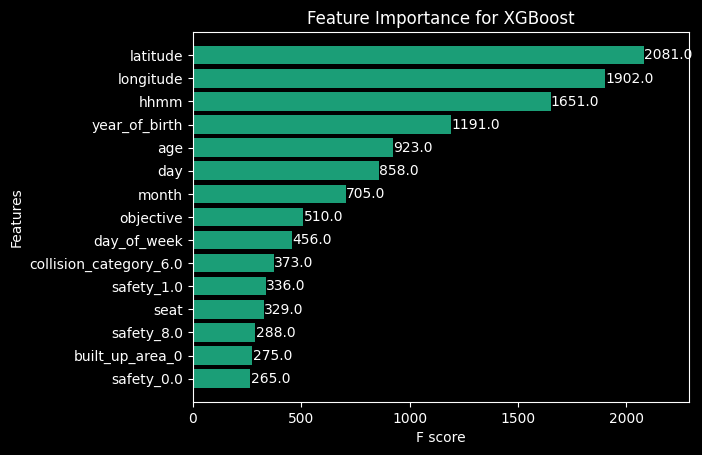

In [15]:
p = plot_importance(best_xgb, max_num_features=N_PLOT, height=0.8, grid="off")
p.set_title("Feature Importance for XGBoost")
p.grid(False)
FILENAME = "rxgb_feat_importance"
visualization.savefig(basename=FILENAME, filepath=PLOT_DIR, formats=PLOT_FILE_FORMATS)

The feature importance plot enables us to identify the most important features used by XGBoost
for the classification problem.
It seems like the location (represented by longitude and latitude) has the highest importance
in this case.

# Random Forest
## Setup and Training

In [16]:
random_forest_clf = RandomForestClassifier(n_estimators=N_RANDOM_FOREST_ESTIMATORS)
random_forest_clf.fit(X_train, y_train)

RandomForestClassifier()

## Evaluation and Interpretation

              precision    recall  f1-score   support

           0       0.67      0.75      0.71      1869
           1       0.60      0.47      0.53      1906
           2       0.68      0.75      0.71      1924

    accuracy                           0.66      5699
   macro avg       0.65      0.66      0.65      5699
weighted avg       0.65      0.66      0.65      5699



['../images/rf_confusion_matrix.png']

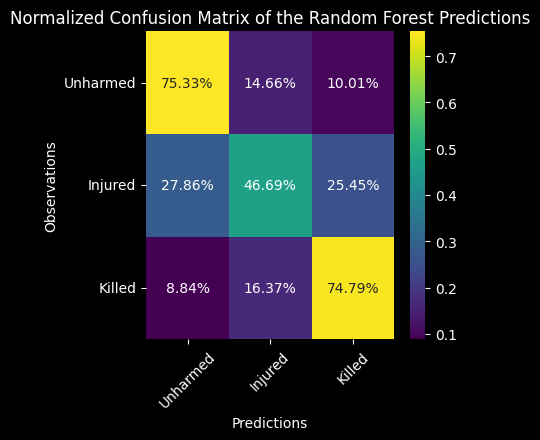

In [17]:
# Predict test values
y_pred = random_forest_clf.predict(X_test)
print(classification_report(y_true=y_test, y_pred=y_pred))

# Plot confusion matrix
visualization.plot_confusion_matrix(
    y_test, y_pred, "Random Forest", normalize="true", figsize=(4, 4)
)

# Save figure
FILENAME = "rf_confusion_matrix"
visualization.savefig(basename=FILENAME, filepath=PLOT_DIR, formats=PLOT_FILE_FORMATS)

## Interpretation with Means of Permutation Importance
Random Forests can be interpreted with impurity-based feature importance, but this approach
has some downsides.
I will therefore use permutation feature importance to analyze the model. For this, I will
calculate the feature importance weights for both the training and the test set and compare them.
Those features that show a high # difference # between the calculated values for training and
test set are considered to be causal for overfitting.

In [18]:
# The permutation performance takes a while to compute.
r_train = permutation_importance(
    random_forest_clf,
    X_train,
    y_train,
    n_repeats=N_PERMUTATION_REPETITIONS,
    random_state=0,
)
r_test = permutation_importance(
    random_forest_clf,
    X_test,
    y_test,
    n_repeats=N_PERMUTATION_REPETITIONS,
    random_state=0,
)

In [19]:
importances_mean_df = pd.DataFrame(index=feature_columns)
importances_std_df = pd.DataFrame(index=feature_columns)

# Mean Values
importances_mean_df["train"] = r_train.importances_mean
importances_mean_df["test"] = r_test.importances_mean

importances_mean_df["train_test_diff"] = abs(
    importances_mean_df["test"] - importances_mean_df["train"]
)
importances_mean_df.sort_values(by="train_test_diff", ascending=False, inplace=True)
importances_mean_df.drop(columns=["train_test_diff"], inplace=True)

# Standard Deviation
importances_std_df["train"] = r_train.importances_std
importances_std_df["test"] = r_test.importances_std
importances_std_df = importances_std_df.reindex_like(importances_mean_df)

['../images/rf_feature_importance.png']

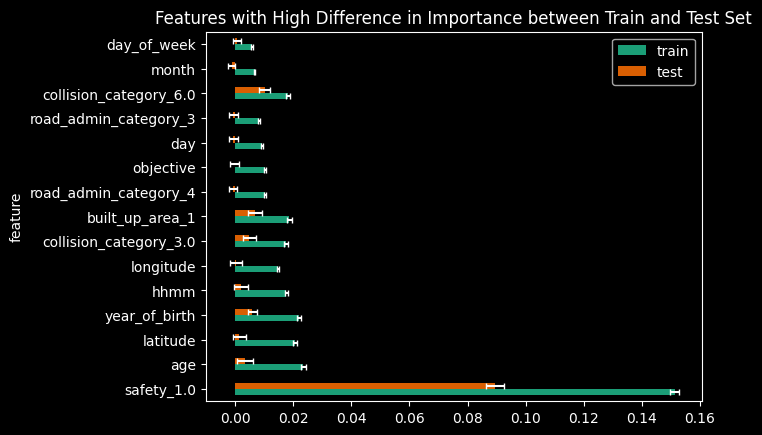

In [20]:
importances_mean_df[["train", "test"]].head(N_PLOT).plot(
    kind="barh", capsize=2, xerr=importances_std_df.head(N_PLOT)
)
plt.title("Features with High Difference in Importance between Train and Test Set")
plt.xlabel("")
plt.ylabel("feature")

visualization.savefig(
    basename="rf_feature_importance", filepath=PLOT_DIR, formats=PLOT_FILE_FORMATS
)

['../images/Random Forest Permutation Feature Importance.png']

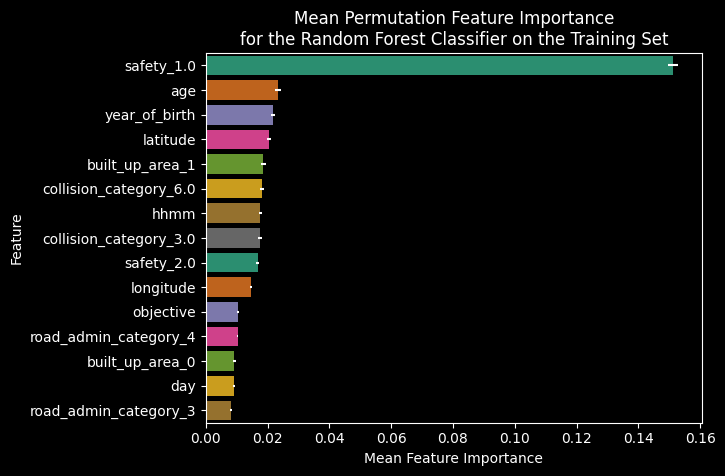

In [21]:
importances_mean_df.sort_values("train", ascending=False, inplace=True)
importances_std_df = importances_std_df.reindex_like(importances_mean_df)
sns.barplot(
    data=importances_mean_df.head(N_PLOT),
    x="train",
    y=importances_mean_df.head(N_PLOT).index.values,
    xerr=importances_std_df["train"].head(N_PLOT),
    capsize=1.0,
    ecolor="white",
    palette="Dark2",
)
plt.title(
    "Mean Permutation Feature Importance\nfor the Random Forest Classifier on the Training Set"
)
plt.xlabel("Mean Feature Importance")
plt.ylabel("Feature")

visualization.savefig(
    basename="Random Forest Permutation Feature Importance",
    filepath=PLOT_DIR,
    formats=PLOT_FILE_FORMATS,
)